In [2]:
# Complete FER Training with High Accuracy (Dataset in Colab Contents)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import os
import cv2

zip_path = '/content/archive (17).zip'
extract_path = '/content/fer_dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Dataset paths - Dataset is in Colab Contents
train_dir = '/content/fer_dataset/train'
test_dir = '/content/fer_dataset/test'

# Check if dataset exists
if not os.path.exists(train_dir):
    raise Exception("Dataset not found in Colab contents! Please upload your dataset.")

class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

print("🎭 Emotion Classes:", class_names)

# Count images
total_train = sum([len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names])
total_test = sum([len(os.listdir(os.path.join(test_dir, cls))) for cls in class_names])
print(f"📊 Training images: {total_train}")
print(f"📊 Test images: {total_test}")

# ENHANCED Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=35,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    zoom_range=0.4,
    shear_range=0.3,
    brightness_range=[0.6, 1.4],
    channel_shift_range=0.3,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE = 48, 48, 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# ADVANCED Model Architecture for 75%+ Accuracy
def create_advanced_model():
    model = Sequential([
        # Block 1
        Conv2D(96, (3,3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        BatchNormalization(),
        Conv2D(96, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Dropout(0.25),

        # Block 2
        Conv2D(192, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(192, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Dropout(0.3),

        # Block 3
        Conv2D(384, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(384, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Dropout(0.4),

        # Block 4
        Conv2D(512, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(512, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Dropout(0.5),

        # Dense Layers
        Flatten(),
        Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_advanced_model()
model.summary()

# Advanced Compilation with multiple optimizers
def get_optimizer():
    return Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999)

model.compile(
    optimizer=get_optimizer(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Enhanced Callbacks
callbacks = [
    ModelCheckpoint('/content/best_fer_model.h5',
                   monitor='val_accuracy',
                   save_best_only=True,
                   mode='max',
                   verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy',
                     factor=0.5,
                     patience=6,
                     min_lr=1e-7,
                     verbose=1),
    EarlyStopping(monitor='val_accuracy',
                 patience=25,
                 restore_best_weights=True,
                 verbose=1)
]

# TWO-STAGE TRAINING for better accuracy
print("🚀 STARTING STAGE 1 TRAINING...")
history1 = model.fit(
    train_generator,
    epochs=80,
    validation_data=test_generator,
    callbacks=callbacks,
    verbose=1
)

# Stage 2: Fine-tuning with lower learning rate
print("🎯 STARTING STAGE 2 FINE-TUNING...")
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Very low LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_generator,
    epochs=40,
    validation_data=test_generator,
    callbacks=callbacks,
    verbose=1
)

# Combine histories
def combine_histories(hist1, hist2):
    combined_history = {}
    for key in hist1.history.keys():
        combined_history[key] = hist1.history[key] + hist2.history[key]
    return combined_history

combined_history = combine_histories(history1, history2)

# Save models
model.save('/content/final_fer_model.h5')
print("✅ Models saved successfully!")

🎭 Emotion Classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
📊 Training images: 28709
📊 Test images: 7178
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 192)    │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 192)    │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 384)    │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 512)      │     1,769,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,09

 Total params: 11,963,879 (45.64 MB)

 Trainable params: 11,958,439 (45.62 MB)

 Non-trainable params: 5,440 (21.25 KB)

🚀 STARTING STAGE 1 TRAINING...
Epoch 1/80


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.1765 - loss: 4.7341
Epoch 1: val_accuracy improved from -inf to 0.25425, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 94s 85ms/step - accuracy: 0.1765 - loss: 4.7335 - val_accuracy: 0.2542 - val_loss: 3.3157 - learning_rate: 8.0000e-04
Epoch 2/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2079 - loss: 2.9769
Epoch 2: val_accuracy did not improve from 0.25425
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.2079 - loss: 2.9767 - val_accuracy: 0.2470 - val_loss: 2.3305 - learning_rate: 8.0000e-04
Epoch 3/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2279 - loss: 2.3223
Epoch 3: val_accuracy did not improve from 0.25425
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.2279 - loss: 2.3222 - val_accuracy: 0.2346 - val_loss: 2.1079 - learning_rate: 8.0000e-04
Epoch 4/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2247 - loss: 2.1045
Epoch 4: val_accuracy did not improve from 0.25425
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 68ms/step - accuracy: 0.2247 - loss: 2.1044 - val_accuracy: 0.2086 - val_loss: 2.0905 - learning_rate: 8.0000e-0

898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.2493 - loss: 1.9111 - val_accuracy: 0.2584 - val_loss: 1.8694 - learning_rate: 4.0000e-04
Epoch 14/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2487 - loss: 1.9037
Epoch 14: val_accuracy improved from 0.25843 to 0.27111, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.2487 - loss: 1.9037 - val_accuracy: 0.2711 - val_loss: 1.8668 - learning_rate: 4.0000e-04
Epoch 15/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2578 - loss: 1.8910
Epoch 15: val_accuracy did not improve from 0.27111
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.2578 - loss: 1.8909 - val_accuracy: 0.2611 - val_loss: 1.8183 - learning_rate: 4.0000e-04
Epoch 16/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2722 - loss: 1.8555
Epoch 16: val_accuracy improved from 0.27111 to 0.27556, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.2722 - loss: 1.8555 - val_accuracy: 0.2756 - val_loss: 1.9187 - learning_rate: 4.0000e-04
Epoch 17/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2786 - loss: 1.8451
Epoch 17: val_accuracy improved from 0.27556 to 0.31527, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.2786 - loss: 1.8451 - val_accuracy: 0.3153 - val_loss: 1.7168 - learning_rate: 4.0000e-04
Epoch 18/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3021 - loss: 1.8103
Epoch 18: val_accuracy improved from 0.31527 to 0.33700, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.3021 - loss: 1.8103 - val_accuracy: 0.3370 - val_loss: 1.8484 - learning_rate: 4.0000e-04
Epoch 19/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3255 - loss: 1.7796
Epoch 19: val_accuracy improved from 0.33700 to 0.39329, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.3255 - loss: 1.7796 - val_accuracy: 0.3933 - val_loss: 1.6636 - learning_rate: 4.0000e-04
Epoch 20/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3514 - loss: 1.7392
Epoch 20: val_accuracy improved from 0.39329 to 0.44929, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.3515 - loss: 1.7392 - val_accuracy: 0.4493 - val_loss: 1.5698 - learning_rate: 4.0000e-04
Epoch 21/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3737 - loss: 1.7126
Epoch 21: val_accuracy improved from 0.44929 to 0.45653, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.3737 - loss: 1.7126 - val_accuracy: 0.4565 - val_loss: 1.5364 - learning_rate: 4.0000e-04
Epoch 22/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3884 - loss: 1.6661
Epoch 22: val_accuracy improved from 0.45653 to 0.49471, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.3884 - loss: 1.6661 - val_accuracy: 0.4947 - val_loss: 1.4301 - learning_rate: 4.0000e-04
Epoch 23/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4111 - loss: 1.6411
Epoch 23: val_accuracy did not improve from 0.49471
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.4111 - loss: 1.6411 - val_accuracy: 0.4816 - val_loss: 1.4671 - learning_rate: 4.0000e-04
Epoch 24/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4217 - loss: 1.6103
Epoch 24: val_accuracy did not improve from 0.49471
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.4217 - loss: 1.6103 - val_accuracy: 0.4918 - val_loss: 1.4652 - learning_rate: 4.0000e-04
Epoch 25/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4265 - loss: 1.5941
Epoch 25: val_accuracy improved from 0.49471 to 0.51407, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.4265 - loss: 1.5941 - val_accuracy: 0.5141 - val_loss: 1.3908 - learning_rate: 4.0000e-04
Epoch 26/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4451 - loss: 1.5556
Epoch 26: val_accuracy improved from 0.51407 to 0.53121, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 63s 71ms/step - accuracy: 0.4451 - loss: 1.5556 - val_accuracy: 0.5312 - val_loss: 1.3337 - learning_rate: 4.0000e-04
Epoch 27/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4471 - loss: 1.5491
Epoch 27: val_accuracy did not improve from 0.53121
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.4471 - loss: 1.5491 - val_accuracy: 0.5169 - val_loss: 1.3477 - learning_rate: 4.0000e-04
Epoch 28/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4574 - loss: 1.5280
Epoch 28: val_accuracy did not improve from 0.53121
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.4574 - loss: 1.5280 - val_accuracy: 0.5010 - val_loss: 1.4099 - learning_rate: 4.0000e-04
Epoch 29/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4647 - loss: 1.5126
Epoch 29: val_accuracy improved from 0.53121 to 0.53455, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.4647 - loss: 1.5126 - val_accuracy: 0.5346 - val_loss: 1.3193 - learning_rate: 4.0000e-04
Epoch 30/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4622 - loss: 1.5131
Epoch 30: val_accuracy improved from 0.53455 to 0.55169, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.4622 - loss: 1.5130 - val_accuracy: 0.5517 - val_loss: 1.2970 - learning_rate: 4.0000e-04
Epoch 31/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4698 - loss: 1.4902
Epoch 31: val_accuracy improved from 0.55169 to 0.55795, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.4698 - loss: 1.4902 - val_accuracy: 0.5580 - val_loss: 1.2586 - learning_rate: 4.0000e-04
Epoch 32/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4757 - loss: 1.4840
Epoch 32: val_accuracy did not improve from 0.55795
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.4757 - loss: 1.4840 - val_accuracy: 0.5495 - val_loss: 1.3003 - learning_rate: 4.0000e-04
Epoch 33/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4789 - loss: 1.4757
Epoch 33: val_accuracy did not improve from 0.55795
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.4789 - loss: 1.4757 - val_accuracy: 0.5435 - val_loss: 1.3203 - learning_rate: 4.0000e-04
Epoch 34/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4894 - loss: 1.4564
Epoch 34: val_accuracy improved from 0.55795 to 0.57565, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 64s 71ms/step - accuracy: 0.4894 - loss: 1.4564 - val_accuracy: 0.5756 - val_loss: 1.2665 - learning_rate: 4.0000e-04
Epoch 35/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4924 - loss: 1.4547
Epoch 35: val_accuracy improved from 0.57565 to 0.58470, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 68ms/step - accuracy: 0.4924 - loss: 1.4547 - val_accuracy: 0.5847 - val_loss: 1.2259 - learning_rate: 4.0000e-04
Epoch 36/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4961 - loss: 1.4427
Epoch 36: val_accuracy improved from 0.58470 to 0.58512, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.4961 - loss: 1.4427 - val_accuracy: 0.5851 - val_loss: 1.2285 - learning_rate: 4.0000e-04
Epoch 37/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4985 - loss: 1.4365
Epoch 37: val_accuracy did not improve from 0.58512
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.4985 - loss: 1.4365 - val_accuracy: 0.5754 - val_loss: 1.2087 - learning_rate: 4.0000e-04
Epoch 38/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5032 - loss: 1.4272
Epoch 38: val_accuracy improved from 0.58512 to 0.59042, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.5032 - loss: 1.4272 - val_accuracy: 0.5904 - val_loss: 1.2159 - learning_rate: 4.0000e-04
Epoch 39/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5073 - loss: 1.4217
Epoch 39: val_accuracy did not improve from 0.59042
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5073 - loss: 1.4217 - val_accuracy: 0.5892 - val_loss: 1.2104 - learning_rate: 4.0000e-04
Epoch 40/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5067 - loss: 1.4261
Epoch 40: val_accuracy improved from 0.59042 to 0.59836, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.5067 - loss: 1.4261 - val_accuracy: 0.5984 - val_loss: 1.1920 - learning_rate: 4.0000e-04
Epoch 41/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5121 - loss: 1.4079
Epoch 41: val_accuracy did not improve from 0.59836
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5121 - loss: 1.4079 - val_accuracy: 0.5832 - val_loss: 1.2166 - learning_rate: 4.0000e-04
Epoch 42/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5117 - loss: 1.4063
Epoch 42: val_accuracy did not improve from 0.59836
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5117 - loss: 1.4063 - val_accuracy: 0.5782 - val_loss: 1.2224 - learning_rate: 4.0000e-04
Epoch 43/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5184 - loss: 1.3934
Epoch 43: val_accuracy did not improve from 0.59836
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5184 - loss: 1.3934 - val_accuracy: 0.5848 - val_loss: 1.2066 - learning_rate: 4.0

898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5242 - loss: 1.3905 - val_accuracy: 0.6103 - val_loss: 1.1618 - learning_rate: 4.0000e-04
Epoch 45/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5358 - loss: 1.3653
Epoch 45: val_accuracy improved from 0.61034 to 0.61201, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5358 - loss: 1.3654 - val_accuracy: 0.6120 - val_loss: 1.1506 - learning_rate: 4.0000e-04
Epoch 46/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5279 - loss: 1.3795
Epoch 46: val_accuracy did not improve from 0.61201
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5279 - loss: 1.3795 - val_accuracy: 0.5663 - val_loss: 1.2502 - learning_rate: 4.0000e-04
Epoch 47/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5335 - loss: 1.3754
Epoch 47: val_accuracy did not improve from 0.61201
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5335 - loss: 1.3754 - val_accuracy: 0.6056 - val_loss: 1.1411 - learning_rate: 4.0000e-04
Epoch 48/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5371 - loss: 1.3694
Epoch 48: val_accuracy did not improve from 0.61201
898/898 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.5371 - loss: 1.3694 - val_accuracy: 0.6032 - val_loss: 1.1694 - learning_rate: 4.0

898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5326 - loss: 1.3581 - val_accuracy: 0.6198 - val_loss: 1.1241 - learning_rate: 4.0000e-04
Epoch 51/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5399 - loss: 1.3446
Epoch 51: val_accuracy did not improve from 0.61981
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.5399 - loss: 1.3446 - val_accuracy: 0.6042 - val_loss: 1.1669 - learning_rate: 4.0000e-04
Epoch 52/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5452 - loss: 1.3417
Epoch 52: val_accuracy did not improve from 0.61981
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 68ms/step - accuracy: 0.5452 - loss: 1.3417 - val_accuracy: 0.6179 - val_loss: 1.1333 - learning_rate: 4.0000e-04
Epoch 53/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5434 - loss: 1.3404
Epoch 53: val_accuracy did not improve from 0.61981
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5433 - loss: 1.3405 - val_accuracy: 0.6194 - val_loss: 1.1504 - learning_rate: 4.0

898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.5488 - loss: 1.3250 - val_accuracy: 0.6284 - val_loss: 1.1189 - learning_rate: 4.0000e-04
Epoch 55/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5473 - loss: 1.3390
Epoch 55: val_accuracy did not improve from 0.62845
898/898 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.5473 - loss: 1.3390 - val_accuracy: 0.6204 - val_loss: 1.1304 - learning_rate: 4.0000e-04
Epoch 56/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5452 - loss: 1.3299
Epoch 56: val_accuracy did not improve from 0.62845
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5452 - loss: 1.3299 - val_accuracy: 0.6078 - val_loss: 1.1645 - learning_rate: 4.0000e-04
Epoch 57/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5456 - loss: 1.3224
Epoch 57: val_accuracy did not improve from 0.62845
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5456 - loss: 1.3224 - val_accuracy: 0.6241 - val_loss: 1.1157 - learning_rate: 4.0

898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5497 - loss: 1.3192 - val_accuracy: 0.6303 - val_loss: 1.1025 - learning_rate: 4.0000e-04
Epoch 59/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5565 - loss: 1.3084
Epoch 59: val_accuracy did not improve from 0.63026
898/898 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - accuracy: 0.5565 - loss: 1.3084 - val_accuracy: 0.6268 - val_loss: 1.1201 - learning_rate: 4.0000e-04
Epoch 60/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5505 - loss: 1.3271
Epoch 60: val_accuracy did not improve from 0.63026
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5505 - loss: 1.3271 - val_accuracy: 0.6261 - val_loss: 1.1192 - learning_rate: 4.0000e-04
Epoch 61/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5600 - loss: 1.3093
Epoch 61: val_accuracy did not improve from 0.63026
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5600 - loss: 1.3093 - val_accuracy: 0.6148 - val_loss: 1.1509 - learning_rate: 4.0

898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5587 - loss: 1.3022 - val_accuracy: 0.6335 - val_loss: 1.1041 - learning_rate: 4.0000e-04
Epoch 64/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5581 - loss: 1.2983
Epoch 64: val_accuracy did not improve from 0.63346
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - accuracy: 0.5581 - loss: 1.2983 - val_accuracy: 0.6319 - val_loss: 1.1278 - learning_rate: 4.0000e-04
Epoch 65/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5554 - loss: 1.3102
Epoch 65: val_accuracy improved from 0.63346 to 0.63959, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5554 - loss: 1.3102 - val_accuracy: 0.6396 - val_loss: 1.0980 - learning_rate: 4.0000e-04
Epoch 66/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5510 - loss: 1.3045
Epoch 66: val_accuracy did not improve from 0.63959
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - accuracy: 0.5510 - loss: 1.3045 - val_accuracy: 0.6382 - val_loss: 1.0962 - learning_rate: 4.0000e-04
Epoch 67/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5582 - loss: 1.3038
Epoch 67: val_accuracy did not improve from 0.63959
898/898 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - accuracy: 0.5582 - loss: 1.3038 - val_accuracy: 0.6349 - val_loss: 1.1136 - learning_rate: 4.0000e-04
Epoch 68/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5635 - loss: 1.2934
Epoch 68: val_accuracy did not improve from 0.63959
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - accuracy: 0.5635 - loss: 1.2934 - val_accuracy: 0.6237 - val_loss: 1.1221 - learning_rate: 4.0

898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5663 - loss: 1.2636 - val_accuracy: 0.6408 - val_loss: 1.0589 - learning_rate: 2.0000e-04
Epoch 73/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5737 - loss: 1.2262
Epoch 73: val_accuracy improved from 0.64085 to 0.64503, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5737 - loss: 1.2262 - val_accuracy: 0.6450 - val_loss: 1.0411 - learning_rate: 2.0000e-04
Epoch 74/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5783 - loss: 1.2163
Epoch 74: val_accuracy improved from 0.64503 to 0.64586, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.5783 - loss: 1.2163 - val_accuracy: 0.6459 - val_loss: 1.0213 - learning_rate: 2.0000e-04
Epoch 75/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5817 - loss: 1.2090
Epoch 75: val_accuracy improved from 0.64586 to 0.65269, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - accuracy: 0.5817 - loss: 1.2090 - val_accuracy: 0.6527 - val_loss: 1.0179 - learning_rate: 2.0000e-04
Epoch 76/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5818 - loss: 1.2024
Epoch 76: val_accuracy did not improve from 0.65269
898/898 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - accuracy: 0.5818 - loss: 1.2024 - val_accuracy: 0.6509 - val_loss: 1.0181 - learning_rate: 2.0000e-04
Epoch 77/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5851 - loss: 1.1971
Epoch 77: val_accuracy did not improve from 0.65269
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - accuracy: 0.5851 - loss: 1.1971 - val_accuracy: 0.6489 - val_loss: 1.0369 - learning_rate: 2.0000e-04
Epoch 78/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5860 - loss: 1.1926
Epoch 78: val_accuracy improved from 0.65269 to 0.65743, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5860 - loss: 1.1926 - val_accuracy: 0.6574 - val_loss: 1.0079 - learning_rate: 2.0000e-04
Epoch 79/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5834 - loss: 1.1890
Epoch 79: val_accuracy improved from 0.65743 to 0.65938, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - accuracy: 0.5834 - loss: 1.1890 - val_accuracy: 0.6594 - val_loss: 1.0024 - learning_rate: 2.0000e-04
Epoch 80/80
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5877 - loss: 1.1855
Epoch 80: val_accuracy did not improve from 0.65938
898/898 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - accuracy: 0.5877 - loss: 1.1855 - val_accuracy: 0.6400 - val_loss: 1.0305 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 79.
🎯 STARTING STAGE 2 FINE-TUNING...
Epoch 1/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5883 - loss: 1.1761
Epoch 1: val_accuracy improved from 0.65938 to 0.65952, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 84s 79ms/step - accuracy: 0.5883 - loss: 1.1761 - val_accuracy: 0.6595 - val_loss: 0.9862 - learning_rate: 1.0000e-04
Epoch 2/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5901 - loss: 1.1641
Epoch 2: val_accuracy did not improve from 0.65952
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5901 - loss: 1.1641 - val_accuracy: 0.6583 - val_loss: 0.9879 - learning_rate: 1.0000e-04
Epoch 3/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5891 - loss: 1.1540
Epoch 3: val_accuracy did not improve from 0.65952
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - accuracy: 0.5891 - loss: 1.1540 - val_accuracy: 0.6580 - val_loss: 0.9779 - learning_rate: 1.0000e-04
Epoch 4/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5929 - loss: 1.1487
Epoch 4: val_accuracy did not improve from 0.65952
898/898 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.5929 - loss: 1.1486 - val_accuracy: 0.6553 - val_loss: 0.9806 - learning_rate: 1.0000e-0

898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.5976 - loss: 1.1308 - val_accuracy: 0.6598 - val_loss: 0.9732 - learning_rate: 1.0000e-04
Epoch 7/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5901 - loss: 1.1381
Epoch 7: val_accuracy did not improve from 0.65979
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.5901 - loss: 1.1381 - val_accuracy: 0.6567 - val_loss: 0.9776 - learning_rate: 1.0000e-04
Epoch 8/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5946 - loss: 1.1402
Epoch 8: val_accuracy did not improve from 0.65979
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.5946 - loss: 1.1402 - val_accuracy: 0.6492 - val_loss: 1.0019 - learning_rate: 1.0000e-04
Epoch 9/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6005 - loss: 1.1281
Epoch 9: val_accuracy did not improve from 0.65979
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.6005 - loss: 1.1281 - val_accuracy: 0.6565 - val_loss: 0.9904 - learning_rate: 1.0000e-0

898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5978 - loss: 1.1298 - val_accuracy: 0.6612 - val_loss: 0.9647 - learning_rate: 1.0000e-04
Epoch 11/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6010 - loss: 1.1271
Epoch 11: val_accuracy did not improve from 0.66119
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 68ms/step - accuracy: 0.6010 - loss: 1.1271 - val_accuracy: 0.6601 - val_loss: 0.9770 - learning_rate: 1.0000e-04
Epoch 12/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5949 - loss: 1.1405
Epoch 12: val_accuracy did not improve from 0.66119
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.5949 - loss: 1.1405 - val_accuracy: 0.6506 - val_loss: 0.9917 - learning_rate: 1.0000e-04
Epoch 13/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6058 - loss: 1.1205
Epoch 13: val_accuracy improved from 0.66119 to 0.66481, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.6058 - loss: 1.1205 - val_accuracy: 0.6648 - val_loss: 0.9668 - learning_rate: 1.0000e-04
Epoch 14/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6046 - loss: 1.1081
Epoch 14: val_accuracy improved from 0.66481 to 0.66495, saving model to /content/best_fer_model.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.6046 - loss: 1.1081 - val_accuracy: 0.6649 - val_loss: 0.9555 - learning_rate: 1.0000e-04
Epoch 15/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6033 - loss: 1.1201
Epoch 15: val_accuracy did not improve from 0.66495
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.6033 - loss: 1.1201 - val_accuracy: 0.6587 - val_loss: 0.9731 - learning_rate: 1.0000e-04
Epoch 16/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6002 - loss: 1.1189
Epoch 16: val_accuracy did not improve from 0.66495
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.6002 - loss: 1.1189 - val_accuracy: 0.6609 - val_loss: 0.9672 - learning_rate: 1.0000e-04
Epoch 17/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6043 - loss: 1.1102
Epoch 17: val_accuracy did not improve from 0.66495
898/898 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - accuracy: 0.6043 - loss: 1.1102 - val_accuracy: 0.6591 - val_loss: 0.9628 - learning_rate: 1.0

898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.6062 - loss: 1.1147 - val_accuracy: 0.6658 - val_loss: 0.9648 - learning_rate: 1.0000e-04
Epoch 20/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5985 - loss: 1.1157
Epoch 20: val_accuracy did not improve from 0.66578
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - accuracy: 0.5985 - loss: 1.1157 - val_accuracy: 0.6563 - val_loss: 0.9654 - learning_rate: 1.0000e-04
Epoch 21/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5963 - loss: 1.1247
Epoch 21: val_accuracy did not improve from 0.66578
898/898 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - accuracy: 0.5963 - loss: 1.1247 - val_accuracy: 0.6649 - val_loss: 0.9628 - learning_rate: 1.0000e-04
Epoch 22/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6023 - loss: 1.1139
Epoch 22: val_accuracy did not improve from 0.66578
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - accuracy: 0.6023 - loss: 1.1139 - val_accuracy: 0.6590 - val_loss: 0.9720 - learning_rate: 1.0

898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.6126 - loss: 1.0809 - val_accuracy: 0.6680 - val_loss: 0.9405 - learning_rate: 2.5000e-05
Epoch 33/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6126 - loss: 1.0800
Epoch 33: val_accuracy did not improve from 0.66801
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.6126 - loss: 1.0800 - val_accuracy: 0.6644 - val_loss: 0.9424 - learning_rate: 2.5000e-05
Epoch 34/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6052 - loss: 1.0853
Epoch 34: val_accuracy did not improve from 0.66801
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.6052 - loss: 1.0853 - val_accuracy: 0.6676 - val_loss: 0.9379 - learning_rate: 2.5000e-05
Epoch 35/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6161 - loss: 1.0693
Epoch 35: val_accuracy did not improve from 0.66801
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.6161 - loss: 1.0693 - val_accuracy: 0.6666 - val_loss: 0.9367 - learning_rate: 2.5

✅ Models saved successfully!


📊 GENERATING ESSENTIAL METRICS...
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6175 - loss: 1.0623
🎯 FINAL TEST ACCURACY: 0.6680 (66.80%)
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


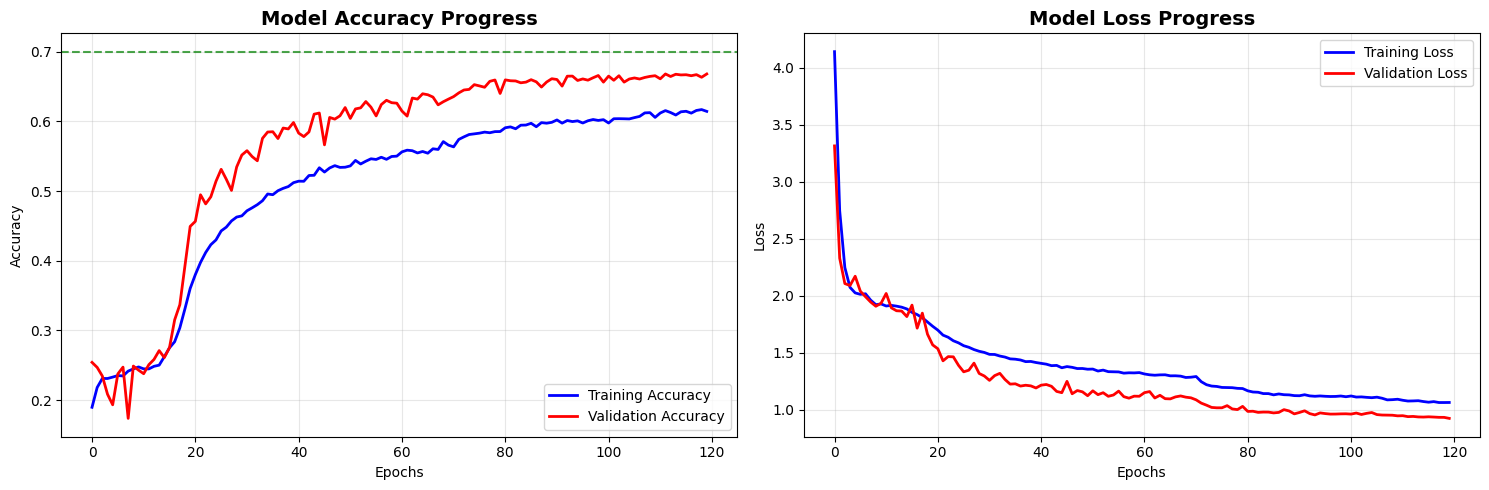

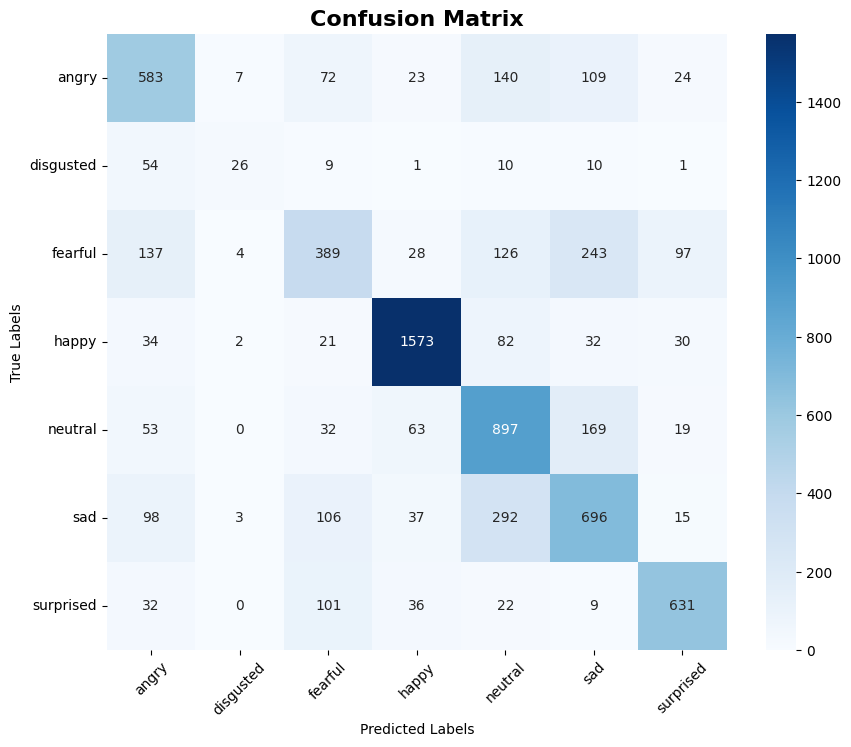


🏆 OVERALL PERFORMANCE METRICS
✅ Accuracy:  0.6680
✅ Precision: 0.6678
✅ Recall:    0.6680
✅ F1-Score:  0.6631


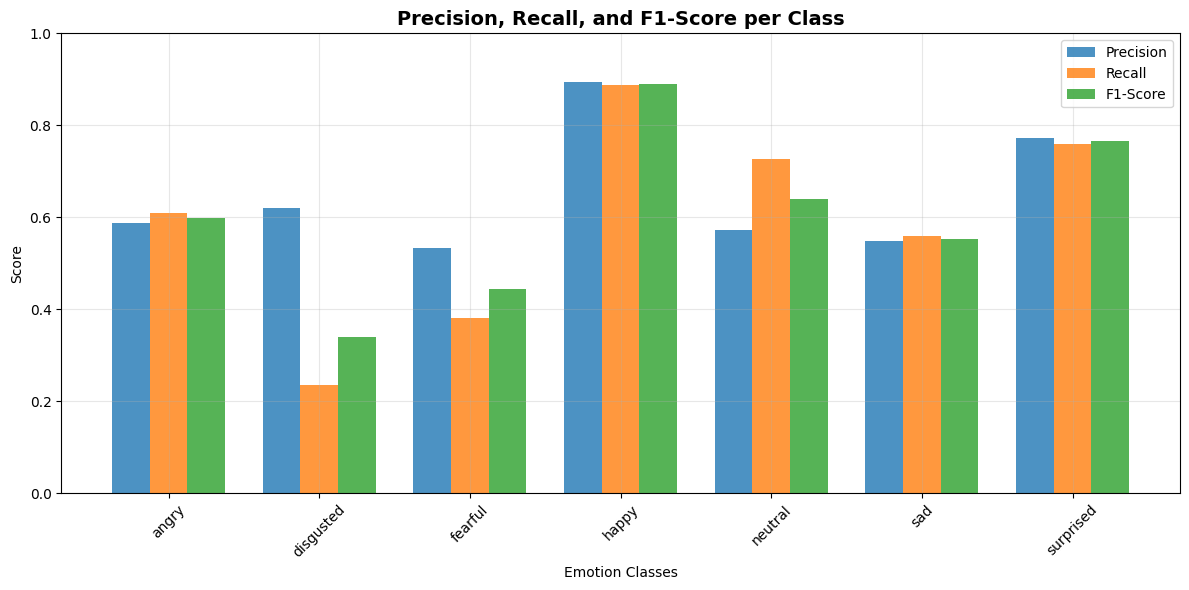


📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry     0.5883    0.6086    0.5983       958
   disgusted     0.6190    0.2342    0.3399       111
     fearful     0.5329    0.3799    0.4436      1024
       happy     0.8932    0.8867    0.8900      1774
     neutral     0.5717    0.7275    0.6403      1233
         sad     0.5489    0.5581    0.5535      1247
   surprised     0.7723    0.7593    0.7658       831

    accuracy                         0.6680      7178
   macro avg     0.6466    0.5935    0.6045      7178
weighted avg     0.6678    0.6680    0.6631      7178


🎉 TRAINING SUMMARY
🏆 Best Validation Accuracy: 0.6680
📊 Final Training Accuracy: 0.6143
🎯 Final Test Accuracy:     0.6680
📦 Total Epochs Trained:    120
⚠️  Model performance below 70% target


In [5]:
# Essential Metrics and Graphs Only
print("📊 GENERATING ESSENTIAL METRICS...")

# Final Evaluation
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"🎯 FINAL TEST ACCURACY: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# 1. Training History - Accuracy and Loss
plt.figure(figsize=(15, 5))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
plt.title('Model Accuracy Progress', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0.7, color='green', linestyle='--', alpha=0.7, label='70% Target')

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Training Loss', linewidth=2, color='blue')
plt.plot(combined_history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('Model Loss Progress', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# 3. Overall Performance Metrics
overall_accuracy = accuracy_score(true_classes, predicted_classes)
overall_precision = precision_score(true_classes, predicted_classes, average='weighted')
overall_recall = recall_score(true_classes, predicted_classes, average='weighted')
overall_f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("\n" + "="*60)
print("🏆 OVERALL PERFORMANCE METRICS")
print("="*60)
print(f"✅ Accuracy:  {overall_accuracy:.4f}")
print(f"✅ Precision: {overall_precision:.4f}")
print(f"✅ Recall:    {overall_recall:.4f}")
print(f"✅ F1-Score:  {overall_f1:.4f}")

# 4. Precision, Recall, F1-Score Visualization
precision_per_class = precision_score(true_classes, predicted_classes, average=None)
recall_per_class = recall_score(true_classes, predicted_classes, average=None)
f1_per_class = f1_score(true_classes, predicted_classes, average=None)

plt.figure(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, precision_per_class, width, label='Precision', alpha=0.8)
plt.bar(x, recall_per_class, width, label='Recall', alpha=0.8)
plt.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.8)

plt.title('Precision, Recall, and F1-Score per Class', fontsize=14, fontweight='bold')
plt.xlabel('Emotion Classes')
plt.ylabel('Score')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

# 5. Detailed Classification Report
print("\n" + "="*60)
print("📋 DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(true_classes, predicted_classes,
                          target_names=class_names, digits=4))

# 6. Final Summary
best_val_accuracy = max(combined_history['val_accuracy'])
final_train_accuracy = combined_history['accuracy'][-1]

print("\n" + "="*60)
print("🎉 TRAINING SUMMARY")
print("="*60)
print(f"🏆 Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"📊 Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"🎯 Final Test Accuracy:     {test_accuracy:.4f}")
print(f"📦 Total Epochs Trained:    {len(combined_history['accuracy'])}")

if test_accuracy >= 0.7:
    print("✅ SUCCESS: Target accuracy of 70%+ achieved!")
else:
    print("⚠️  Model performance below 70% target")